# Imports

In [1]:
import json
from ultralytics import YOLO
import numpy as np
import os
import torch
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Constants

In [2]:
# check the json files
train_json_file = r"../insuranceData/train.json"
test_json_file = r"../insuranceData/test.json"
val_json_file = r"../insuranceData/val.json"

# Utilities

In [3]:
def load_jsons(json_name):
    with open(json_name,"r") as json_file:
        train_json_handler = json.load(json_file)
        return train_json_handler
def convert_cocotov11(annotations, img_w, img_h):
    
    current_bbox = annotations['bbox']
    cat_id = annotations["category_id"]
    x = current_bbox[0]
    y = current_bbox[1]
    w = current_bbox[2]
    h = current_bbox[3]
    # Finding midpoints
    x_centre = (x + (x+w))/2
    y_centre = (y + (y+h))/2
    
    # Normalization
    x_centre = x_centre / img_w
    y_centre = y_centre / img_h
    w = w / img_w
    h = h / img_h
    
    # Limiting upto fix number of decimal places
    x_centre = format(x_centre, '.6f')
    y_centre = format(y_centre, '.6f')
    w = format(w, '.6f')
    h = format(h, '.6f')

    return cat_id, x_centre, y_centre, w, h


def createtxt(filename, listxywh,newpath):
    filename = filename.split(".")[0]
    with open(newpath+"/"+filename+".txt","w") as filep:
        for i in listxywh:
            filep.write(f"{i[0]-1} {i[1]} {i[2]} {i[3]} {i[4]} \n")
            

In [4]:
training_dict = load_jsons(train_json_file)
testing_dict = load_jsons(test_json_file)
validation_dict = load_jsons(val_json_file)

In [5]:
training_dict["categories"]

[{'id': 1, 'name': 'dent', 'supercategory': 'car damages'},
 {'id': 2, 'name': 'scratch', 'supercategory': 'car damages'},
 {'id': 3, 'name': 'crack', 'supercategory': 'car damages'},
 {'id': 4, 'name': 'glass shatter', 'supercategory': 'car damages'},
 {'id': 5, 'name': 'lamp broken', 'supercategory': 'car damages'},
 {'id': 6, 'name': 'tire flat', 'supercategory': 'car damages'}]

In [6]:
def createDataOrganiser(set_dict, set_name):
    print(set_name,"*"*50)
    
    nametoidmap = {}
    
    idtocategoriesmap = {}
    
    for image in set_dict["images"]:
        nametoidmap[image["id"]] = image
    
    for annot in set_dict["annotations"]:
        props = nametoidmap[annot["image_id"]]
        image_name, width, height = props["file_name"], props["width"], props["height"]
        cat_id, x_centre, y_centre, w, h = convert_cocotov11(annot,width, height)
        if image_name in idtocategoriesmap:
            idtocategoriesmap[image_name].append([cat_id, x_centre, y_centre, w, h])
        else:
            idtocategoriesmap[image_name] = [[cat_id, x_centre, y_centre, w, h],]
    newpath = "../insuranceData/"+set_name+"/labels"
    print(idtocategoriesmap.keys())
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    for key,value in idtocategoriesmap.items():
        createtxt(key,value,newpath)
    return nametoidmap,newpath

In [7]:
training_name, training_path = createDataOrganiser(training_dict,"train")
testing_name, testing_path = createDataOrganiser(testing_dict,"test")
validation_name, validation_path = createDataOrganiser(validation_dict,"val")

train **************************************************
dict_keys(['000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg', '000006.jpg', '000007.jpg', '000008.jpg', '000009.jpg', '000010.jpg', '000011.jpg', '000014.jpg', '000018.jpg', '000019.jpg', '000020.jpg', '000021.jpg', '000022.jpg', '000026.jpg', '000027.jpg', '000028.jpg', '000029.jpg', '000030.jpg', '000031.jpg', '000032.jpg', '000036.jpg', '000037.jpg', '000039.jpg', '000041.jpg', '000043.jpg', '000045.jpg', '000046.jpg', '000048.jpg', '000049.jpg', '000050.jpg', '000051.jpg', '000052.jpg', '000053.jpg', '000055.jpg', '000056.jpg', '000061.jpg', '000062.jpg', '000063.jpg', '000064.jpg', '000065.jpg', '000066.jpg', '000067.jpg', '000068.jpg', '000069.jpg', '000070.jpg', '000071.jpg', '000072.jpg', '000073.jpg', '000074.jpg', '000075.jpg', '000076.jpg', '000077.jpg', '000078.jpg', '000079.jpg', '000081.jpg', '000085.jpg', '000087.jpg', '000092.jpg', '000093.jpg', '000094.jpg', '000095.jpg', '000096.jpg', '000098.

# Model Training

In [8]:
model = YOLO("yolo11n.pt") 

In [9]:
torch.cuda.empty_cache()
results = model.train(
    data = "data.yaml",
  epochs=500,
)

Ultralytics 8.3.40  Python-3.11.0rc2 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=data.yaml, epochs=500, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True,

train: Scanning C:\Projects\insuranceData\train\labels.cache... 2816 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2816/2816 [00:00<?, ?it/s]
val: Scanning C:\Projects\insuranceData\val\labels.cache... 810 images, 0 backgrounds, 0 corrupt: 100%|██████████| 810/810 [00:00<?, ?it/s]


Plotting labels to runs\detect\train5\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train5
Starting training for 500 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/500      2.45G       1.47      3.659      1.646         77        640: 100%|██████████| 176/176 [00:43<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.17it/s]


                   all        810       1744      0.495      0.303      0.309      0.255

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/500       2.5G       1.47      2.845      1.626         73        640: 100%|██████████| 176/176 [00:45<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:07<00:00,  3.48it/s]


                   all        810       1744      0.485      0.375      0.366      0.252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/500      2.39G      1.525      2.585      1.659         67        640: 100%|██████████| 176/176 [01:54<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:12<00:00,  2.06it/s]


                   all        810       1744      0.469      0.365       0.36      0.244

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/500      2.39G      1.605      2.588      1.724         59        640: 100%|██████████| 176/176 [01:02<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.37it/s]


                   all        810       1744      0.395      0.403      0.375      0.248

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/500      2.39G      1.575      2.451      1.711         61        640: 100%|██████████| 176/176 [01:01<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.45it/s]


                   all        810       1744        0.6      0.362       0.37      0.243

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/500      2.39G      1.545      2.328      1.674         84        640: 100%|██████████| 176/176 [01:01<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.51it/s]

                   all        810       1744      0.369       0.41      0.371      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/500      2.39G      1.508      2.242      1.649         81        640: 100%|██████████| 176/176 [01:02<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.54it/s]

                   all        810       1744      0.463      0.412      0.408      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/500      2.39G      1.493      2.154      1.634         82        640: 100%|██████████| 176/176 [01:01<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.55it/s]

                   all        810       1744      0.484      0.484      0.483      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/500      2.39G      1.468      2.097      1.616         89        640: 100%|██████████| 176/176 [01:01<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.56it/s]

                   all        810       1744      0.468      0.482      0.442      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/500      2.39G      1.437      2.016      1.591         62        640: 100%|██████████| 176/176 [01:00<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.55it/s]


                   all        810       1744      0.576      0.495      0.505      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/500      2.39G      1.432       1.99      1.577         71        640: 100%|██████████| 176/176 [01:02<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.63it/s]


                   all        810       1744      0.709      0.454      0.498      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/500      2.39G      1.408       1.96      1.574         64        640: 100%|██████████| 176/176 [00:45<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.96it/s]

                   all        810       1744      0.546      0.463      0.457      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/500      2.39G      1.388      1.904      1.541         73        640: 100%|██████████| 176/176 [00:43<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.68it/s]

                   all        810       1744      0.529      0.524      0.528       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/500      2.39G      1.397      1.887      1.549         52        640: 100%|██████████| 176/176 [00:44<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.35it/s]

                   all        810       1744      0.586      0.485      0.502      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/500      2.39G      1.376       1.85      1.531         77        640: 100%|██████████| 176/176 [00:45<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.22it/s]

                   all        810       1744      0.577      0.527       0.55      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/500      2.38G      1.355      1.811      1.511         75        640: 100%|██████████| 176/176 [00:47<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.27it/s]

                   all        810       1744      0.574       0.55      0.544      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/500      2.39G      1.349      1.777      1.505         67        640: 100%|██████████| 176/176 [00:46<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.36it/s]

                   all        810       1744      0.606      0.552      0.555      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/500      2.39G      1.329      1.747      1.498         56        640: 100%|██████████| 176/176 [00:46<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.25it/s]

                   all        810       1744      0.601      0.563      0.569      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/500      2.39G      1.334      1.745      1.493         65        640: 100%|██████████| 176/176 [00:47<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.29it/s]

                   all        810       1744      0.541      0.531       0.54      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/500      2.39G      1.309      1.696      1.476         51        640: 100%|██████████| 176/176 [00:46<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.25it/s]

                   all        810       1744      0.517      0.546      0.512      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/500      2.39G      1.312      1.696      1.472         85        640: 100%|██████████| 176/176 [00:46<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.30it/s]

                   all        810       1744      0.604      0.555      0.571      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/500      2.39G      1.295      1.657      1.467         78        640: 100%|██████████| 176/176 [00:47<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.62it/s]

                   all        810       1744      0.606      0.549      0.578      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/500      2.39G      1.307      1.678      1.476         79        640: 100%|██████████| 176/176 [00:43<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.39it/s]

                   all        810       1744      0.568      0.566      0.554      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/500      2.39G      1.302      1.654      1.467         69        640: 100%|██████████| 176/176 [00:45<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.30it/s]

                   all        810       1744      0.582      0.557      0.555      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/500       2.4G      1.262      1.622       1.45         45        640: 100%|██████████| 176/176 [00:45<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.15it/s]

                   all        810       1744      0.603      0.563      0.569      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/500      2.39G      1.281      1.635      1.455         69        640: 100%|██████████| 176/176 [00:43<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.28it/s]

                   all        810       1744      0.614      0.589      0.596      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/500      2.38G      1.258      1.591      1.434         69        640: 100%|██████████| 176/176 [00:45<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.36it/s]

                   all        810       1744      0.644       0.59      0.607      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/500      2.38G      1.239      1.562      1.428         61        640: 100%|██████████| 176/176 [00:42<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.99it/s]

                   all        810       1744      0.588      0.566       0.57      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/500      2.41G      1.255      1.565      1.431         84        640: 100%|██████████| 176/176 [00:40<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.96it/s]

                   all        810       1744      0.607      0.575      0.586      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/500      2.39G      1.248      1.536      1.416         80        640: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.35it/s]

                   all        810       1744      0.606       0.56      0.578      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/500      2.38G      1.243      1.515      1.411         69        640: 100%|██████████| 176/176 [00:43<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.93it/s]

                   all        810       1744      0.664      0.573      0.609      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/500      2.39G       1.22        1.5      1.394         65        640: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.08it/s]

                   all        810       1744      0.626      0.594      0.621      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/500      2.39G      1.224      1.503      1.406         79        640: 100%|██████████| 176/176 [00:45<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.32it/s]

                   all        810       1744      0.541       0.58      0.585      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/500      2.39G       1.23      1.512      1.404         75        640: 100%|██████████| 176/176 [00:44<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.99it/s]

                   all        810       1744      0.642      0.603      0.617      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/500      2.39G      1.211      1.473      1.397        105        640: 100%|██████████| 176/176 [00:39<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.20it/s]

                   all        810       1744      0.639      0.583      0.617      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/500      2.38G      1.217      1.471      1.402        105        640: 100%|██████████| 176/176 [00:45<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.30it/s]

                   all        810       1744      0.632      0.617      0.627       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/500      2.39G      1.218      1.472      1.392         53        640: 100%|██████████| 176/176 [00:46<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.33it/s]

                   all        810       1744      0.621      0.631      0.627       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/500      2.39G      1.192      1.433      1.385         89        640: 100%|██████████| 176/176 [00:46<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.40it/s]

                   all        810       1744      0.655      0.611      0.621      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/500      2.42G      1.192      1.434      1.374         65        640: 100%|██████████| 176/176 [00:43<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.03it/s]

                   all        810       1744       0.62      0.618      0.628      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/500      2.39G      1.202      1.437      1.386         84        640: 100%|██████████| 176/176 [00:39<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.02it/s]

                   all        810       1744      0.696      0.577      0.627      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/500      2.39G      1.184      1.403      1.361         78        640: 100%|██████████| 176/176 [00:45<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.37it/s]

                   all        810       1744      0.642      0.592      0.621      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/500      2.39G      1.196      1.409      1.375         82        640: 100%|██████████| 176/176 [00:46<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.37it/s]

                   all        810       1744      0.612      0.606      0.622      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/500      2.39G      1.179      1.404      1.374         64        640: 100%|██████████| 176/176 [00:46<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.32it/s]

                   all        810       1744      0.636      0.611      0.631      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/500      2.41G       1.18      1.382       1.37         84        640: 100%|██████████| 176/176 [00:46<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.28it/s]

                   all        810       1744      0.676      0.601      0.636      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/500      2.39G      1.169      1.378      1.364         49        640: 100%|██████████| 176/176 [00:43<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.99it/s]

                   all        810       1744      0.661      0.612      0.638      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/500      2.41G      1.172      1.377      1.364         80        640: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.30it/s]

                   all        810       1744      0.653       0.64      0.648      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/500      2.39G      1.157       1.35      1.357         68        640: 100%|██████████| 176/176 [00:46<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.22it/s]

                   all        810       1744      0.657      0.615      0.629      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/500      2.41G      1.155       1.37      1.354         83        640: 100%|██████████| 176/176 [00:44<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.87it/s]

                   all        810       1744       0.65      0.625      0.648      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/500      2.39G       1.18      1.347      1.349        107        640: 100%|██████████| 176/176 [00:39<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.94it/s]

                   all        810       1744      0.623      0.635      0.638        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/500      2.38G      1.144      1.343      1.347         70        640: 100%|██████████| 176/176 [00:45<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.33it/s]

                   all        810       1744      0.645      0.626      0.632        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/500      2.39G      1.148      1.328      1.343         60        640: 100%|██████████| 176/176 [00:46<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.37it/s]

                   all        810       1744      0.648      0.617      0.633      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/500      2.41G      1.134      1.296      1.332         68        640: 100%|██████████| 176/176 [00:47<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.30it/s]

                   all        810       1744      0.673      0.604      0.644      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/500      2.38G      1.148      1.326      1.349         48        640: 100%|██████████| 176/176 [00:46<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.28it/s]

                   all        810       1744      0.666      0.615      0.648      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/500      2.39G      1.139        1.3      1.335         79        640: 100%|██████████| 176/176 [00:46<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.21it/s]

                   all        810       1744      0.648      0.643      0.646      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/500      2.41G      1.128      1.302      1.321         84        640: 100%|██████████| 176/176 [00:47<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.19it/s]

                   all        810       1744      0.629      0.638       0.65      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/500      2.39G      1.142      1.321      1.343         94        640: 100%|██████████| 176/176 [00:46<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.27it/s]

                   all        810       1744      0.676      0.623      0.648      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/500      2.39G      1.142      1.307      1.331         79        640: 100%|██████████| 176/176 [00:46<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.25it/s]

                   all        810       1744      0.648      0.652      0.651      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/500      2.38G      1.122      1.271      1.322         66        640: 100%|██████████| 176/176 [00:47<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.28it/s]

                   all        810       1744        0.7       0.61      0.646      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/500      2.39G      1.109      1.256      1.314         87        640: 100%|██████████| 176/176 [00:46<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.35it/s]

                   all        810       1744      0.691      0.628      0.654      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/500      2.39G      1.116      1.256      1.318         67        640: 100%|██████████| 176/176 [00:46<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.28it/s]

                   all        810       1744      0.645      0.645      0.648      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/500      2.38G      1.117      1.253      1.318         93        640: 100%|██████████| 176/176 [00:46<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.89it/s]

                   all        810       1744      0.694      0.615      0.652      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/500      2.38G      1.126      1.268       1.32         69        640: 100%|██████████| 176/176 [00:59<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.58it/s]


                   all        810       1744      0.685       0.63      0.661      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/500      2.38G      1.113       1.25      1.305        108        640: 100%|██████████| 176/176 [01:02<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.54it/s]


                   all        810       1744       0.65      0.624      0.657      0.526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/500      2.38G      1.107      1.227      1.307         80        640: 100%|██████████| 176/176 [01:03<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.54it/s]

                   all        810       1744      0.669      0.642      0.657       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/500      2.39G      1.108       1.24      1.304         70        640: 100%|██████████| 176/176 [01:01<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.61it/s]

                   all        810       1744      0.678      0.635       0.66      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/500      2.39G       1.09      1.221      1.295         74        640: 100%|██████████| 176/176 [01:01<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.62it/s]


                   all        810       1744      0.705      0.635      0.658       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/500      2.38G      1.092      1.205      1.291         61        640: 100%|██████████| 176/176 [01:01<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.58it/s]


                   all        810       1744      0.656      0.638      0.649      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/500      2.39G      1.092      1.201      1.296         62        640: 100%|██████████| 176/176 [01:02<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.60it/s]


                   all        810       1744      0.721      0.639      0.666      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/500      2.38G      1.082      1.185      1.284         69        640: 100%|██████████| 176/176 [01:01<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.60it/s]

                   all        810       1744      0.663      0.665      0.666      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/500      2.39G      1.088      1.197       1.29         76        640: 100%|██████████| 176/176 [01:01<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.59it/s]


                   all        810       1744      0.654      0.656      0.661      0.524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/500      2.39G      1.077      1.196      1.288         91        640: 100%|██████████| 176/176 [01:01<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.41it/s]

                   all        810       1744      0.684      0.638       0.66      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/500      2.39G      1.079      1.174      1.283         85        640: 100%|██████████| 176/176 [01:01<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.51it/s]

                   all        810       1744      0.683      0.646      0.659      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/500      2.38G      1.084      1.174      1.287         71        640: 100%|██████████| 176/176 [01:01<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.59it/s]

                   all        810       1744      0.695      0.653       0.67      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/500      2.38G      1.078      1.174      1.285         70        640: 100%|██████████| 176/176 [01:01<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.56it/s]

                   all        810       1744      0.612      0.659      0.654      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/500      2.39G       1.07      1.147      1.275         70        640: 100%|██████████| 176/176 [01:00<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.65it/s]


                   all        810       1744        0.7       0.62      0.661      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/500      2.39G       1.06       1.13      1.266         79        640: 100%|██████████| 176/176 [01:00<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.62it/s]


                   all        810       1744      0.686      0.657      0.665      0.525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/500      2.41G       1.06      1.126      1.269         89        640: 100%|██████████| 176/176 [01:08<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:07<00:00,  3.26it/s]


                   all        810       1744      0.657       0.66      0.667      0.524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/500      2.38G      1.074      1.153       1.28         77        640: 100%|██████████| 176/176 [00:56<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.58it/s]

                   all        810       1744      0.668      0.653      0.673      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/500      2.41G      1.066       1.14      1.276         91        640: 100%|██████████| 176/176 [01:03<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.46it/s]


                   all        810       1744      0.743      0.629      0.676      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/500      2.39G      1.068      1.128      1.261         61        640: 100%|██████████| 176/176 [01:05<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.55it/s]


                   all        810       1744      0.646      0.668      0.671      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/500      2.39G      1.049      1.129      1.266         81        640: 100%|██████████| 176/176 [01:04<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.60it/s]


                   all        810       1744       0.67      0.656      0.672      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/500      2.39G       1.06      1.128      1.264         71        640: 100%|██████████| 176/176 [01:04<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.55it/s]


                   all        810       1744       0.67      0.668      0.675      0.533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/500      2.39G      1.045      1.107      1.258         79        640: 100%|██████████| 176/176 [01:04<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.55it/s]


                   all        810       1744       0.69      0.657      0.677      0.533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/500      2.39G      1.037      1.112      1.252         80        640: 100%|██████████| 176/176 [01:05<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.58it/s]


                   all        810       1744      0.691      0.654      0.678      0.535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/500      2.39G      1.052      1.132      1.255         82        640: 100%|██████████| 176/176 [01:05<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.54it/s]


                   all        810       1744      0.715      0.641      0.671      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/500      2.39G      1.046      1.086      1.253         54        640: 100%|██████████| 176/176 [01:04<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.57it/s]


                   all        810       1744      0.712      0.651      0.668      0.526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/500      2.38G      1.027      1.079      1.244         86        640: 100%|██████████| 176/176 [01:05<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.56it/s]


                   all        810       1744      0.664      0.653      0.665      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/500      2.39G      1.041      1.084      1.259         87        640: 100%|██████████| 176/176 [01:04<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.56it/s]

                   all        810       1744      0.731      0.649      0.678       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/500      2.38G       1.03      1.074      1.244         51        640: 100%|██████████| 176/176 [01:04<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.55it/s]


                   all        810       1744      0.722      0.652      0.688      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/500      2.39G      1.027      1.061      1.234         91        640: 100%|██████████| 176/176 [01:03<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.58it/s]


                   all        810       1744      0.681      0.639      0.672      0.538

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/500      2.39G      1.026      1.073      1.242        110        640: 100%|██████████| 176/176 [01:02<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.61it/s]

                   all        810       1744      0.728      0.644      0.683      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/500      2.38G      1.024      1.061      1.236         74        640: 100%|██████████| 176/176 [00:54<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.43it/s]

                   all        810       1744      0.672       0.66      0.677      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/500      2.39G      1.024      1.054      1.237         74        640: 100%|██████████| 176/176 [00:45<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.65it/s]

                   all        810       1744      0.687      0.686      0.689      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/500      2.38G      1.034      1.068      1.245         70        640: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.90it/s]

                   all        810       1744      0.702      0.649      0.677      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/500      2.39G      1.031      1.053       1.24         77        640: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.83it/s]

                   all        810       1744      0.701      0.651      0.681      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/500      2.39G      1.024      1.051      1.231         62        640: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.50it/s]

                   all        810       1744      0.716      0.663      0.685      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/500      2.38G      1.023       1.05      1.239         81        640: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.91it/s]

                   all        810       1744      0.688      0.677      0.677      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/500      2.39G      1.019      1.033      1.229         86        640: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.58it/s]

                   all        810       1744      0.729       0.66      0.681      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/500      2.39G      1.014      1.033      1.232         77        640: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.28it/s]

                   all        810       1744      0.703      0.649      0.676      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/500      2.39G     0.9994      1.016      1.224         71        640: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.61it/s]

                   all        810       1744      0.668      0.677      0.682      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/500      2.38G      1.008      1.011      1.224         78        640: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.58it/s]

                   all        810       1744      0.708      0.664      0.691      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/500      2.39G       1.02      1.028      1.227         73        640: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.68it/s]

                   all        810       1744      0.684      0.667      0.675      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/500      2.39G     0.9935      1.012      1.223         69        640: 100%|██████████| 176/176 [00:42<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.47it/s]

                   all        810       1744      0.685      0.683      0.682      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/500      2.39G      1.009      1.023      1.219         70        640: 100%|██████████| 176/176 [00:42<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.59it/s]

                   all        810       1744      0.709      0.647      0.679      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/500      2.38G      1.016      1.011      1.225         78        640: 100%|██████████| 176/176 [00:42<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.72it/s]

                   all        810       1744      0.698      0.641       0.68      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/500      2.39G      1.002       1.02      1.217         63        640: 100%|██████████| 176/176 [00:41<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.34it/s]

                   all        810       1744       0.69      0.668      0.682      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/500      2.39G       1.01      1.006      1.217         60        640: 100%|██████████| 176/176 [00:51<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.22it/s]

                   all        810       1744      0.678      0.672      0.675      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/500      2.38G      1.002     0.9914      1.215         63        640: 100%|██████████| 176/176 [00:57<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.52it/s]

                   all        810       1744       0.67      0.684      0.685      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/500      2.39G     0.9884     0.9923      1.209         69        640: 100%|██████████| 176/176 [00:42<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.14it/s]

                   all        810       1744       0.68      0.682      0.693      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/500      2.39G      1.002      1.005      1.215         80        640: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.19it/s]

                   all        810       1744      0.694      0.663       0.68      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/500      2.39G     0.9994     0.9917      1.216         57        640: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.64it/s]

                   all        810       1744      0.752      0.642      0.689      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/500      2.38G     0.9844     0.9733      1.206         71        640: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.62it/s]

                   all        810       1744      0.718      0.653      0.689      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/500      2.42G     0.9856      0.975        1.2         89        640: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.61it/s]

                   all        810       1744      0.712      0.676      0.688      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/500      2.39G      0.984     0.9755      1.206         95        640: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.55it/s]

                   all        810       1744      0.707      0.668      0.689      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/500      2.38G     0.9835     0.9853        1.2         68        640: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.71it/s]

                   all        810       1744      0.704      0.659      0.674      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/500      2.45G     0.9715      0.966      1.199         75        640: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.00it/s]

                   all        810       1744       0.71      0.667      0.694      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/500      2.39G     0.9826      0.965      1.203         56        640: 100%|██████████| 176/176 [00:40<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.17it/s]

                   all        810       1744        0.7      0.676      0.695      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/500      2.39G      0.966     0.9545      1.194         57        640: 100%|██████████| 176/176 [00:39<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.82it/s]

                   all        810       1744      0.714      0.669      0.696      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/500      2.38G     0.9747     0.9436      1.194         79        640: 100%|██████████| 176/176 [00:42<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.42it/s]

                   all        810       1744      0.681      0.686      0.689      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/500      2.38G     0.9746     0.9512      1.192         69        640: 100%|██████████| 176/176 [00:42<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.23it/s]

                   all        810       1744      0.715      0.676      0.692      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/500      2.39G     0.9768     0.9578      1.196         54        640: 100%|██████████| 176/176 [00:43<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.61it/s]

                   all        810       1744      0.711      0.677      0.698      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/500      2.39G     0.9684     0.9456      1.194         75        640: 100%|██████████| 176/176 [00:42<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.67it/s]

                   all        810       1744      0.719      0.673      0.697       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/500      2.38G     0.9597     0.9301       1.19         67        640: 100%|██████████| 176/176 [00:43<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.56it/s]

                   all        810       1744      0.694       0.67      0.689      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/500      2.39G     0.9702      0.933      1.189         82        640: 100%|██████████| 176/176 [00:42<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.43it/s]

                   all        810       1744      0.713      0.683      0.691      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/500      2.41G     0.9602     0.9296      1.189         63        640: 100%|██████████| 176/176 [00:43<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.74it/s]

                   all        810       1744       0.68       0.69      0.692      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/500      2.39G     0.9656     0.9291      1.191        106        640: 100%|██████████| 176/176 [00:45<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.85it/s]

                   all        810       1744      0.713      0.676      0.697      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/500      2.42G     0.9588     0.9218      1.184         82        640: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.91it/s]

                   all        810       1744      0.733       0.66      0.687      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/500      2.39G      0.957     0.9183      1.183         86        640: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.81it/s]

                   all        810       1744      0.713      0.679      0.694      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/500      2.41G     0.9513     0.9015      1.179         58        640: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.94it/s]

                   all        810       1744      0.714      0.674      0.698      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/500      2.38G     0.9489     0.9051      1.173         81        640: 100%|██████████| 176/176 [00:39<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.84it/s]

                   all        810       1744      0.724      0.659      0.693      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/500      2.39G     0.9632     0.9189      1.189         92        640: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.83it/s]

                   all        810       1744      0.716      0.675      0.687      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/500      2.39G     0.9544     0.9027       1.18         73        640: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.91it/s]

                   all        810       1744      0.726      0.688      0.695      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/500      2.39G      0.937     0.8936      1.176         65        640: 100%|██████████| 176/176 [00:39<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.03it/s]

                   all        810       1744      0.712      0.687      0.695      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/500      2.41G     0.9551     0.9048      1.173         69        640: 100%|██████████| 176/176 [00:39<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.14it/s]

                   all        810       1744      0.698      0.672      0.695      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/500      2.38G     0.9514     0.9084      1.182         56        640: 100%|██████████| 176/176 [00:40<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.03it/s]

                   all        810       1744      0.714       0.67      0.698      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/500      2.38G     0.9497     0.8985       1.17         80        640: 100%|██████████| 176/176 [00:39<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.11it/s]

                   all        810       1744       0.69      0.704      0.698      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/500      2.39G     0.9514     0.9003      1.177         92        640: 100%|██████████| 176/176 [00:39<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.13it/s]

                   all        810       1744       0.72      0.681      0.699       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/500      2.38G     0.9413      0.886      1.167         76        640: 100%|██████████| 176/176 [00:39<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.08it/s]

                   all        810       1744      0.735      0.677      0.698      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/500      2.38G     0.9506     0.8931      1.172         65        640: 100%|██████████| 176/176 [00:39<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.21it/s]

                   all        810       1744      0.721      0.665      0.694      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/500      2.38G     0.9515     0.8867      1.168         80        640: 100%|██████████| 176/176 [00:39<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.23it/s]

                   all        810       1744      0.704      0.693        0.7      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/500      2.39G     0.9423     0.8899      1.166         70        640: 100%|██████████| 176/176 [00:39<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.14it/s]

                   all        810       1744      0.723       0.67      0.693      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/500      2.38G     0.9265     0.8784      1.158         75        640: 100%|██████████| 176/176 [00:39<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.16it/s]

                   all        810       1744      0.726      0.678      0.699      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/500      2.39G     0.9313     0.8533      1.161         82        640: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.02it/s]

                   all        810       1744      0.733      0.668      0.695       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/500      2.38G     0.9392     0.8635      1.165         65        640: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.04it/s]

                   all        810       1744      0.706      0.692        0.7      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/500      2.38G     0.9338     0.8595      1.163         81        640: 100%|██████████| 176/176 [00:40<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.04it/s]

                   all        810       1744       0.73       0.67      0.689      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/500      2.39G     0.9427     0.8736      1.165         82        640: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.93it/s]

                   all        810       1744       0.74      0.666      0.697      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/500      2.38G     0.9236     0.8698      1.162         97        640: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.83it/s]

                   all        810       1744      0.716      0.668      0.692      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/500      2.38G     0.9324     0.8638      1.163         70        640: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.97it/s]

                   all        810       1744      0.722       0.67      0.695      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/500      2.38G     0.9386     0.8719      1.164         61        640: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.16it/s]

                   all        810       1744      0.721      0.681      0.697      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/500      2.41G     0.9269      0.849      1.157         69        640: 100%|██████████| 176/176 [00:39<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.05it/s]

                   all        810       1744      0.714       0.69      0.694      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/500      2.38G     0.9243     0.8557      1.158         71        640: 100%|██████████| 176/176 [00:38<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.18it/s]

                   all        810       1744      0.698      0.671      0.694      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/500      2.39G     0.9229     0.8629      1.152         66        640: 100%|██████████| 176/176 [00:38<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.14it/s]

                   all        810       1744      0.722      0.659      0.688      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/500      2.38G     0.9188     0.8522      1.161         65        640: 100%|██████████| 176/176 [00:39<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.93it/s]

                   all        810       1744      0.706      0.682      0.694       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/500      2.38G     0.9191     0.8544      1.154         59        640: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.98it/s]

                   all        810       1744      0.734      0.665      0.691      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/500      2.39G     0.8994     0.8426      1.146         68        640: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.82it/s]

                   all        810       1744      0.726      0.674      0.702      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/500      2.38G     0.9207     0.8366      1.153         59        640: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.03it/s]

                   all        810       1744      0.736      0.674      0.704      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/500      2.38G     0.9197     0.8386      1.156         52        640: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.89it/s]

                   all        810       1744      0.744      0.666      0.703      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/500      2.38G     0.9082     0.8387      1.154         83        640: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.55it/s]

                   all        810       1744      0.734      0.685      0.702      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/500      2.39G     0.9204     0.8512      1.156         79        640: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.78it/s]

                   all        810       1744      0.725      0.679      0.699      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/500      2.41G     0.9022     0.8119      1.142         85        640: 100%|██████████| 176/176 [00:39<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.18it/s]

                   all        810       1744      0.759      0.667        0.7      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/500      2.41G     0.9107     0.8307      1.147         59        640: 100%|██████████| 176/176 [00:39<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.16it/s]

                   all        810       1744      0.742      0.673      0.703      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/500      2.39G     0.9195     0.8221      1.153         82        640: 100%|██████████| 176/176 [00:39<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.00it/s]

                   all        810       1744      0.737      0.681      0.708      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/500      2.38G     0.9096     0.8216      1.142         63        640: 100%|██████████| 176/176 [00:39<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.16it/s]

                   all        810       1744      0.786      0.648      0.703      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/500      2.38G     0.8955     0.8019      1.134         78        640: 100%|██████████| 176/176 [00:39<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.21it/s]

                   all        810       1744      0.766      0.669      0.706      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/500      2.41G     0.8997     0.8206      1.139         57        640: 100%|██████████| 176/176 [00:39<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.12it/s]

                   all        810       1744      0.769      0.657      0.703      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/500      2.38G     0.9062     0.8248      1.144         67        640: 100%|██████████| 176/176 [00:39<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.11it/s]

                   all        810       1744      0.753      0.669      0.705      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/500      2.39G     0.8933     0.8132      1.136         67        640: 100%|██████████| 176/176 [00:39<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.18it/s]

                   all        810       1744      0.737      0.672      0.702      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/500      2.39G     0.8913     0.8016      1.134         71        640: 100%|██████████| 176/176 [00:39<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.16it/s]

                   all        810       1744      0.723      0.686      0.704      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/500      2.38G     0.9027      0.806      1.134         76        640: 100%|██████████| 176/176 [00:39<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.21it/s]

                   all        810       1744       0.75      0.663      0.702      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/500      2.38G     0.8986     0.8092      1.136         66        640: 100%|██████████| 176/176 [00:39<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.23it/s]

                   all        810       1744       0.69      0.714      0.712      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/500      2.38G     0.8893     0.8122      1.134         56        640: 100%|██████████| 176/176 [00:39<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.03it/s]

                   all        810       1744      0.779      0.664      0.712      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/500      2.38G     0.8872     0.7961      1.131         68        640: 100%|██████████| 176/176 [00:39<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.21it/s]

                   all        810       1744      0.778      0.668      0.711      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/500      2.38G     0.8885     0.7886      1.128         57        640: 100%|██████████| 176/176 [00:39<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [07:51<00:00, 18.14s/it]

                   all        810       1744      0.746      0.667      0.701      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/500      2.38G     0.8765     0.7838      1.126         69        640: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.57it/s]

                   all        810       1744       0.75      0.666      0.706      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/500      2.41G     0.8995     0.7977      1.136         72        640: 100%|██████████| 176/176 [00:38<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.72it/s]

                   all        810       1744      0.764      0.664      0.705      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/500      2.38G     0.8878     0.7763      1.129         63        640: 100%|██████████| 176/176 [00:42<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.91it/s]

                   all        810       1744       0.73      0.675      0.706      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/500      2.38G      0.881     0.7841      1.127         82        640: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  3.94it/s]

                   all        810       1744      0.717      0.689      0.706      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/500      2.38G     0.8825     0.7908      1.129         92        640: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.64it/s]

                   all        810       1744      0.717      0.678      0.698      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/500      2.39G     0.8813     0.7894      1.127         90        640: 100%|██████████| 176/176 [00:43<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.66it/s]

                   all        810       1744      0.707      0.689        0.7      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/500      2.38G     0.8929     0.7874      1.133         67        640: 100%|██████████| 176/176 [00:48<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.05it/s]

                   all        810       1744      0.721      0.697      0.709      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/500      2.38G     0.8811      0.789      1.122         75        640: 100%|██████████| 176/176 [00:42<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.69it/s]

                   all        810       1744       0.72      0.692      0.704      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/500      2.38G     0.8837     0.7828      1.128         75        640: 100%|██████████| 176/176 [00:44<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  3.93it/s]

                   all        810       1744      0.713      0.702      0.707      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/500      2.38G     0.8671     0.7732      1.112         78        640: 100%|██████████| 176/176 [00:45<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.46it/s]

                   all        810       1744       0.72      0.695      0.706      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/500      2.39G     0.8738     0.7787      1.119         71        640: 100%|██████████| 176/176 [00:45<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.47it/s]

                   all        810       1744      0.743      0.685      0.702      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/500      2.36G     0.8791      0.776      1.122         92        640: 100%|██████████| 176/176 [00:45<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.51it/s]

                   all        810       1744      0.757      0.669      0.702      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/500      2.38G     0.8673     0.7659      1.119         80        640: 100%|██████████| 176/176 [00:40<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.29it/s]

                   all        810       1744      0.765      0.661      0.703      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/500      2.39G     0.8667     0.7625      1.112         71        640: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.19it/s]

                   all        810       1744      0.722      0.677      0.704      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/500      2.39G     0.8686     0.7649      1.115         88        640: 100%|██████████| 176/176 [00:38<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.21it/s]

                   all        810       1744      0.736      0.677        0.7      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/500      2.39G     0.8591     0.7608      1.108         83        640: 100%|██████████| 176/176 [00:38<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.16it/s]

                   all        810       1744      0.731      0.686      0.704      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/500      2.39G      0.865     0.7493      1.109         81        640: 100%|██████████| 176/176 [00:38<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.30it/s]

                   all        810       1744      0.729      0.687      0.703      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/500      2.39G     0.8706     0.7552      1.114         62        640: 100%|██████████| 176/176 [00:43<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.38it/s]

                   all        810       1744      0.765      0.675      0.709      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/500      2.41G     0.8647     0.7582      1.117         93        640: 100%|██████████| 176/176 [00:46<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.41it/s]

                   all        810       1744       0.73      0.694       0.71      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/500      2.39G     0.8561     0.7432       1.11         81        640: 100%|██████████| 176/176 [00:45<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.45it/s]

                   all        810       1744      0.739      0.683      0.706      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/500      2.39G     0.8517     0.7365      1.104         69        640: 100%|██████████| 176/176 [00:43<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.76it/s]

                   all        810       1744      0.735      0.676      0.707      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/500      2.39G     0.8598     0.7436      1.108         84        640: 100%|██████████| 176/176 [00:42<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.65it/s]

                   all        810       1744      0.706      0.698      0.702      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/500      2.38G     0.8671     0.7586      1.118         84        640: 100%|██████████| 176/176 [00:42<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.72it/s]

                   all        810       1744      0.729      0.686      0.705      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/500      2.38G     0.8516     0.7474      1.108         78        640: 100%|██████████| 176/176 [00:48<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  3.73it/s]

                   all        810       1744      0.749      0.675      0.705      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/500      2.39G     0.8678      0.757      1.115         74        640: 100%|██████████| 176/176 [00:42<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.80it/s]

                   all        810       1744      0.761       0.67      0.709       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/500      2.39G     0.8553     0.7514      1.108         89        640: 100%|██████████| 176/176 [00:43<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  3.95it/s]

                   all        810       1744      0.779       0.66      0.709       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/500      2.41G     0.8523      0.742      1.104         75        640: 100%|██████████| 176/176 [00:45<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.78it/s]

                   all        810       1744      0.759      0.669      0.709       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/500      2.39G     0.8485     0.7321      1.102         73        640: 100%|██████████| 176/176 [00:44<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.61it/s]

                   all        810       1744      0.783      0.655       0.71      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/500      2.39G     0.8546      0.741      1.107         57        640: 100%|██████████| 176/176 [00:45<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.17it/s]

                   all        810       1744      0.731      0.678      0.707      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/500      2.39G     0.8517     0.7373      1.106         60        640: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.88it/s]

                   all        810       1744      0.751      0.677      0.707      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/500      2.38G     0.8551     0.7467      1.103         74        640: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.02it/s]

                   all        810       1744      0.755       0.67      0.703      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/500      2.38G     0.8535     0.7333      1.104         82        640: 100%|██████████| 176/176 [00:39<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.20it/s]

                   all        810       1744      0.777      0.663      0.706      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/500      2.36G     0.8534     0.7329      1.108         57        640: 100%|██████████| 176/176 [00:39<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.56it/s]

                   all        810       1744      0.794      0.664      0.709       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/500      2.38G     0.8457     0.7227      1.101         63        640: 100%|██████████| 176/176 [00:43<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.50it/s]

                   all        810       1744      0.781      0.662      0.705      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/500      2.38G     0.8455     0.7292        1.1         51        640: 100%|██████████| 176/176 [00:44<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.52it/s]

                   all        810       1744      0.781       0.66      0.703      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/500      2.39G     0.8446     0.7141      1.096         79        640: 100%|██████████| 176/176 [00:44<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.55it/s]

                   all        810       1744      0.778      0.662      0.706      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/500      2.41G     0.8413     0.7192      1.096         59        640: 100%|██████████| 176/176 [00:43<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.76it/s]

                   all        810       1744      0.754      0.673      0.705       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/500      2.39G      0.843     0.7082        1.1         78        640: 100%|██████████| 176/176 [00:44<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.45it/s]

                   all        810       1744      0.735      0.677      0.702      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/500      2.41G     0.8443     0.7326      1.098         65        640: 100%|██████████| 176/176 [00:46<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  3.91it/s]

                   all        810       1744      0.742      0.685      0.705      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/500      2.39G     0.8343     0.7158      1.096         48        640: 100%|██████████| 176/176 [00:46<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  3.96it/s]

                   all        810       1744      0.759      0.675      0.706      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/500      2.38G     0.8355     0.7162      1.097         81        640: 100%|██████████| 176/176 [00:44<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.46it/s]

                   all        810       1744      0.784      0.659      0.705      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/500      2.41G     0.8302     0.7114      1.088         65        640: 100%|██████████| 176/176 [00:39<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.05it/s]

                   all        810       1744      0.764      0.669      0.703      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/500      2.39G     0.8442     0.7213        1.1         74        640: 100%|██████████| 176/176 [00:39<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.10it/s]

                   all        810       1744      0.747       0.68      0.703      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/500      2.39G     0.8522     0.7285      1.105         63        640: 100%|██████████| 176/176 [00:38<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.03it/s]

                   all        810       1744      0.736      0.694      0.706      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/500      2.39G     0.8399     0.7162      1.098         85        640: 100%|██████████| 176/176 [00:39<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.12it/s]

                   all        810       1744      0.744      0.682      0.705      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/500      2.38G     0.8317     0.7229      1.096         86        640: 100%|██████████| 176/176 [00:39<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.93it/s]

                   all        810       1744      0.762      0.675      0.706      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/500      2.38G     0.8348     0.7072       1.09         71        640: 100%|██████████| 176/176 [00:40<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.83it/s]

                   all        810       1744      0.777      0.666      0.706      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/500      2.38G     0.8327     0.7152      1.096         81        640: 100%|██████████| 176/176 [00:39<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.47it/s]

                   all        810       1744      0.783      0.669      0.707      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/500      2.39G     0.8249     0.6993      1.086         69        640: 100%|██████████| 176/176 [00:42<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.21it/s]

                   all        810       1744      0.741      0.683      0.705      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/500      2.38G      0.838     0.7059      1.091         63        640: 100%|██████████| 176/176 [00:39<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.41it/s]

                   all        810       1744      0.756      0.679      0.706      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/500      2.38G       0.83     0.6992      1.085         68        640: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.89it/s]

                   all        810       1744      0.755      0.673      0.705      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/500      2.39G     0.8251       0.69      1.085         72        640: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.49it/s]

                   all        810       1744      0.738      0.689      0.705      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/500      2.39G     0.8318     0.7004      1.092         92        640: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.51it/s]

                   all        810       1744      0.734      0.693      0.706      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/500      2.42G     0.8223     0.6964      1.086         72        640: 100%|██████████| 176/176 [00:42<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.50it/s]

                   all        810       1744      0.728      0.694      0.706      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/500      2.38G     0.8224     0.6923      1.085         61        640: 100%|██████████| 176/176 [00:39<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.20it/s]

                   all        810       1744      0.745       0.68      0.704      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/500      2.38G     0.8135     0.6909      1.082         76        640: 100%|██████████| 176/176 [00:39<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.82it/s]

                   all        810       1744      0.745      0.683      0.707      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/500      2.38G     0.8202     0.6979       1.08         73        640: 100%|██████████| 176/176 [00:39<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.31it/s]

                   all        810       1744       0.74      0.686      0.711      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/500      2.39G     0.8217     0.6878      1.088         61        640: 100%|██████████| 176/176 [00:39<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.98it/s]

                   all        810       1744      0.757      0.674       0.71      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/500      2.39G     0.8128     0.6832      1.076         68        640: 100%|██████████| 176/176 [00:40<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.06it/s]

                   all        810       1744      0.737      0.692      0.713      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/500      2.39G     0.8322     0.6919      1.086         78        640: 100%|██████████| 176/176 [00:39<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.00it/s]

                   all        810       1744      0.755      0.682       0.71       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/500      2.38G     0.8077      0.684      1.078         84        640: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.79it/s]

                   all        810       1744      0.752      0.682      0.709      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/500      2.39G      0.813     0.6828      1.077        101        640: 100%|██████████| 176/176 [00:39<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.15it/s]

                   all        810       1744      0.756      0.683      0.712      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/500      2.38G     0.8169     0.6809      1.078         82        640: 100%|██████████| 176/176 [00:38<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.29it/s]

                   all        810       1744      0.776      0.668      0.712      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/500      2.39G      0.808     0.6838      1.083         73        640: 100%|██████████| 176/176 [00:39<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.19it/s]

                   all        810       1744      0.768       0.67      0.707      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/500      2.38G     0.8031     0.6757      1.073         74        640: 100%|██████████| 176/176 [00:38<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.94it/s]

                   all        810       1744      0.771      0.671      0.709      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/500      2.39G     0.8164     0.6778      1.078         91        640: 100%|██████████| 176/176 [00:39<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.10it/s]

                   all        810       1744      0.758      0.676      0.713      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/500      2.38G     0.8062     0.6809      1.072         74        640: 100%|██████████| 176/176 [00:38<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.23it/s]

                   all        810       1744       0.75      0.683      0.712      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/500      2.39G     0.8062      0.677      1.077         62        640: 100%|██████████| 176/176 [00:43<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.26it/s]

                   all        810       1744       0.77      0.668      0.714      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/500      2.39G     0.8098     0.6762      1.077         89        640: 100%|██████████| 176/176 [00:46<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.22it/s]

                   all        810       1744      0.761       0.67      0.713      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/500      2.39G     0.8147     0.6688      1.073        100        640: 100%|██████████| 176/176 [00:46<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.23it/s]

                   all        810       1744      0.768      0.669      0.713      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/500      2.38G     0.7965     0.6578      1.071         87        640: 100%|██████████| 176/176 [00:44<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.37it/s]

                   all        810       1744      0.765      0.671      0.713      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/500      2.38G     0.8083     0.6683      1.076         63        640: 100%|██████████| 176/176 [00:46<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.32it/s]

                   all        810       1744      0.762      0.673      0.713      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/500      2.38G     0.8135      0.665      1.075         59        640: 100%|██████████| 176/176 [00:46<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.31it/s]

                   all        810       1744      0.773      0.674      0.714      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/500      2.38G     0.8001     0.6703      1.071         96        640: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.35it/s]

                   all        810       1744      0.769      0.678      0.715      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/500      2.39G     0.8155     0.6766      1.076         69        640: 100%|██████████| 176/176 [00:46<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.32it/s]

                   all        810       1744      0.766       0.68      0.717      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/500      2.39G     0.8024     0.6649      1.071         74        640: 100%|██████████| 176/176 [00:45<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.31it/s]

                   all        810       1744      0.768      0.672      0.717      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/500      2.38G      0.785     0.6492      1.063         62        640: 100%|██████████| 176/176 [00:46<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.25it/s]

                   all        810       1744      0.744      0.685      0.714      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    251/500      2.39G     0.7943     0.6684      1.075        101        640: 100%|██████████| 176/176 [00:46<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.35it/s]

                   all        810       1744      0.747      0.684      0.715      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    252/500      2.39G     0.7929     0.6429      1.063         76        640: 100%|██████████| 176/176 [00:43<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.85it/s]

                   all        810       1744      0.741      0.689      0.715      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    253/500      2.39G     0.7925     0.6639      1.064         85        640: 100%|██████████| 176/176 [00:43<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.29it/s]

                   all        810       1744      0.752      0.685      0.714      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    254/500      2.38G     0.7925     0.6573      1.067         79        640: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.97it/s]

                   all        810       1744      0.755      0.682      0.713      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    255/500      2.38G     0.7967     0.6545      1.067         82        640: 100%|██████████| 176/176 [00:45<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.26it/s]

                   all        810       1744      0.758      0.681      0.713      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    256/500      2.39G     0.7797     0.6472      1.062         63        640: 100%|██████████| 176/176 [00:45<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.35it/s]

                   all        810       1744      0.749       0.68      0.711      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    257/500      2.39G     0.7888     0.6511      1.064         60        640: 100%|██████████| 176/176 [00:46<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.32it/s]

                   all        810       1744      0.752      0.679      0.711      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    258/500      2.38G     0.7942     0.6496      1.067         63        640: 100%|██████████| 176/176 [00:46<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.44it/s]

                   all        810       1744      0.755      0.679      0.709      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    259/500      2.39G     0.7849     0.6426      1.061         80        640: 100%|██████████| 176/176 [00:46<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.35it/s]

                   all        810       1744       0.75      0.683      0.709      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    260/500      2.38G     0.7961     0.6629      1.068         74        640: 100%|██████████| 176/176 [00:45<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.37it/s]

                   all        810       1744      0.758      0.679       0.71      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    261/500      2.39G     0.7839     0.6413      1.063         82        640: 100%|██████████| 176/176 [00:46<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.29it/s]

                   all        810       1744      0.757       0.68      0.712      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    262/500      2.39G     0.7888     0.6447      1.058         85        640: 100%|██████████| 176/176 [00:46<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.35it/s]

                   all        810       1744      0.753      0.683       0.71       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    263/500      2.38G     0.7817     0.6446      1.061         81        640: 100%|██████████| 176/176 [00:46<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.41it/s]

                   all        810       1744      0.744      0.687      0.711       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    264/500      2.38G     0.7818     0.6268      1.057         77        640: 100%|██████████| 176/176 [00:45<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.32it/s]

                   all        810       1744       0.77      0.675      0.711      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    265/500      2.38G     0.7917     0.6417      1.065         78        640: 100%|██████████| 176/176 [00:44<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.96it/s]

                   all        810       1744       0.77      0.673      0.711      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    266/500      2.38G     0.7833     0.6361      1.062         77        640: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.92it/s]

                   all        810       1744      0.766      0.671      0.711      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    267/500      2.39G     0.7811     0.6382      1.059         81        640: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.98it/s]

                   all        810       1744      0.758      0.682      0.711      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    268/500      2.38G     0.7689      0.637      1.054         75        640: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.85it/s]

                   all        810       1744      0.756      0.682      0.712      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    269/500      2.41G     0.7857     0.6368      1.056         68        640: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.86it/s]

                   all        810       1744      0.773      0.673      0.712      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    270/500      2.38G     0.7755     0.6247      1.057         83        640: 100%|██████████| 176/176 [00:39<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.19it/s]

                   all        810       1744      0.776       0.67      0.712      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    271/500      2.38G     0.7625     0.6268      1.051         79        640: 100%|██████████| 176/176 [00:40<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.93it/s]

                   all        810       1744      0.762       0.68      0.712       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    272/500      2.38G     0.7716       0.63      1.055         84        640: 100%|██████████| 176/176 [00:39<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.21it/s]

                   all        810       1744      0.745      0.688      0.712       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    273/500      2.38G     0.7715      0.631      1.055         55        640: 100%|██████████| 176/176 [00:38<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.24it/s]

                   all        810       1744      0.761      0.682      0.712      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    274/500      2.39G     0.7679     0.6313      1.056         73        640: 100%|██████████| 176/176 [00:39<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.13it/s]

                   all        810       1744       0.76      0.687      0.712      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    275/500      2.38G     0.7629     0.6198      1.049         84        640: 100%|██████████| 176/176 [00:39<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.16it/s]

                   all        810       1744      0.762      0.685      0.712      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    276/500      2.38G     0.7791     0.6293      1.057         66        640: 100%|██████████| 176/176 [00:39<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.31it/s]

                   all        810       1744      0.762       0.68      0.711      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    277/500      2.39G     0.7689     0.6202      1.051         74        640: 100%|██████████| 176/176 [00:39<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.30it/s]

                   all        810       1744      0.749      0.692      0.713      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    278/500      2.41G     0.7661     0.6293      1.052         75        640: 100%|██████████| 176/176 [00:38<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.10it/s]

                   all        810       1744      0.744      0.694      0.712      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    279/500      2.38G      0.763     0.6137      1.049         83        640: 100%|██████████| 176/176 [00:39<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.13it/s]

                   all        810       1744      0.745      0.693      0.714      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    280/500      2.38G      0.762     0.6091      1.046         63        640: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.04it/s]

                   all        810       1744       0.77      0.673      0.712      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    281/500      2.39G     0.7744     0.6249      1.051         81        640: 100%|██████████| 176/176 [00:39<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.02it/s]

                   all        810       1744      0.765      0.677      0.714      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    282/500      2.38G     0.7648     0.6187       1.05         67        640: 100%|██████████| 176/176 [00:38<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.12it/s]

                   all        810       1744      0.759       0.68      0.713      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    283/500      2.38G     0.7661     0.6189      1.047         74        640: 100%|██████████| 176/176 [00:39<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.31it/s]

                   all        810       1744      0.765      0.676      0.713      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    284/500      2.39G     0.7678     0.6193      1.052         79        640: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.99it/s]

                   all        810       1744       0.76      0.684      0.714      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    285/500      2.38G     0.7638     0.6119      1.045        111        640: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.44it/s]

                   all        810       1744      0.773      0.679      0.714      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    286/500      2.38G     0.7544     0.6032      1.045         68        640: 100%|██████████| 176/176 [00:39<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.28it/s]

                   all        810       1744      0.771      0.677      0.715      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    287/500      2.41G     0.7631     0.6111       1.05         66        640: 100%|██████████| 176/176 [00:38<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.17it/s]

                   all        810       1744      0.758      0.682      0.715      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    288/500      2.39G     0.7556     0.5997      1.043         64        640: 100%|██████████| 176/176 [00:39<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.14it/s]

                   all        810       1744      0.746      0.696      0.717      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    289/500      2.41G     0.7646     0.6114       1.05         69        640: 100%|██████████| 176/176 [00:39<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.01it/s]

                   all        810       1744      0.745      0.699      0.717      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    290/500      2.38G     0.7587     0.6085      1.044         66        640: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.38it/s]

                   all        810       1744      0.747      0.696      0.717      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    291/500      2.39G     0.7551     0.6128      1.042         58        640: 100%|██████████| 176/176 [00:39<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.13it/s]

                   all        810       1744      0.752      0.697      0.717      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    292/500      2.39G     0.7516     0.6071      1.039         76        640: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.09it/s]

                   all        810       1744      0.752      0.698      0.718      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    293/500      2.38G     0.7534     0.6068      1.037         76        640: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.01it/s]

                   all        810       1744      0.755      0.691      0.716      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    294/500      2.38G     0.7508     0.6066      1.039         86        640: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.93it/s]

                   all        810       1744      0.753       0.69      0.716      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    295/500      2.41G     0.7481     0.6032      1.038         83        640: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.03it/s]

                   all        810       1744      0.768      0.681      0.717      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    296/500      2.38G     0.7412     0.5943      1.039         64        640: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.95it/s]

                   all        810       1744      0.771      0.683      0.717      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    297/500      2.38G     0.7555     0.5984      1.044         68        640: 100%|██████████| 176/176 [00:40<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.32it/s]

                   all        810       1744      0.767      0.682      0.718      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    298/500      2.41G     0.7566      0.604      1.043         89        640: 100%|██████████| 176/176 [00:38<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.12it/s]

                   all        810       1744      0.782      0.669      0.717      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    299/500      2.38G     0.7567      0.604      1.048         49        640: 100%|██████████| 176/176 [00:38<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.43it/s]

                   all        810       1744      0.768       0.68      0.717      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    300/500      2.41G     0.7486     0.6014       1.04         81        640: 100%|██████████| 176/176 [00:38<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.09it/s]

                   all        810       1744      0.766      0.684      0.718      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    301/500      2.38G     0.7427     0.5918      1.041         61        640: 100%|██████████| 176/176 [00:38<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.24it/s]

                   all        810       1744      0.762      0.685      0.717      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    302/500      2.38G     0.7382     0.5876      1.032         71        640: 100%|██████████| 176/176 [00:40<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.11it/s]

                   all        810       1744      0.761      0.686      0.717      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    303/500      2.38G     0.7424     0.5875      1.036         79        640: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.58it/s]

                   all        810       1744      0.763      0.685      0.717      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    304/500      2.38G     0.7416     0.5839      1.039         61        640: 100%|██████████| 176/176 [00:42<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.86it/s]

                   all        810       1744       0.76      0.686      0.716      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    305/500      2.38G     0.7417     0.5762      1.033         73        640: 100%|██████████| 176/176 [00:42<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.90it/s]

                   all        810       1744      0.756      0.688      0.715      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    306/500      2.39G     0.7356     0.5917      1.035         88        640: 100%|██████████| 176/176 [00:42<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.01it/s]

                   all        810       1744       0.76      0.687      0.715      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    307/500      2.39G     0.7394     0.5834       1.03         73        640: 100%|██████████| 176/176 [00:38<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.64it/s]

                   all        810       1744       0.76      0.683      0.715      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    308/500      2.38G     0.7372     0.5917      1.031         65        640: 100%|██████████| 176/176 [00:39<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.87it/s]

                   all        810       1744       0.77      0.671      0.714      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    309/500      2.39G     0.7347     0.5832      1.034         67        640: 100%|██████████| 176/176 [00:39<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.87it/s]

                   all        810       1744      0.768      0.674      0.714      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    310/500      2.39G     0.7491     0.5909      1.037         75        640: 100%|██████████| 176/176 [00:39<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.96it/s]

                   all        810       1744      0.778      0.673      0.715      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    311/500      2.38G     0.7301     0.5724      1.026         88        640: 100%|██████████| 176/176 [00:39<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.05it/s]

                   all        810       1744      0.774      0.674      0.715      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    312/500      2.38G     0.7357     0.5832      1.029         73        640: 100%|██████████| 176/176 [00:39<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.03it/s]

                   all        810       1744      0.774      0.673      0.717      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    313/500      2.39G     0.7326     0.5792      1.032         69        640: 100%|██████████| 176/176 [00:39<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.24it/s]

                   all        810       1744      0.773      0.674      0.715      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    314/500      2.38G     0.7225     0.5731      1.027         73        640: 100%|██████████| 176/176 [00:38<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.15it/s]

                   all        810       1744      0.764      0.678      0.715      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    315/500      2.38G     0.7384     0.5877      1.035         80        640: 100%|██████████| 176/176 [00:39<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.03it/s]

                   all        810       1744      0.744      0.689      0.715      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    316/500      2.39G     0.7258     0.5807      1.026         93        640: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.30it/s]

                   all        810       1744      0.748       0.69      0.715      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    317/500      2.38G     0.7346     0.5797      1.033         80        640: 100%|██████████| 176/176 [00:39<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.30it/s]

                   all        810       1744      0.746      0.691      0.714      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    318/500      2.39G     0.7288     0.5908      1.031         73        640: 100%|██████████| 176/176 [00:39<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.26it/s]

                   all        810       1744      0.744      0.693      0.713      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    319/500      2.38G     0.7298      0.581      1.028         67        640: 100%|██████████| 176/176 [00:39<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.41it/s]

                   all        810       1744      0.743      0.692      0.714      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    320/500      2.39G      0.726     0.5862      1.027         95        640: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.87it/s]

                   all        810       1744      0.737      0.701      0.714      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    321/500      2.39G     0.7409     0.5871      1.029         70        640: 100%|██████████| 176/176 [00:40<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.85it/s]

                   all        810       1744      0.733      0.703      0.714      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    322/500      2.39G     0.7302     0.5722      1.027         66        640: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.03it/s]

                   all        810       1744      0.766      0.678      0.714      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    323/500      2.38G     0.7414     0.5779      1.033         77        640: 100%|██████████| 176/176 [00:39<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.13it/s]

                   all        810       1744      0.766      0.679      0.714      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    324/500      2.38G     0.7238     0.5738      1.023         84        640: 100%|██████████| 176/176 [00:40<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.76it/s]

                   all        810       1744      0.766      0.678      0.715      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    325/500      2.38G     0.7275      0.578      1.025         67        640: 100%|██████████| 176/176 [00:39<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.76it/s]

                   all        810       1744      0.729      0.704      0.715      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    326/500      2.38G     0.7282     0.5722      1.024         60        640: 100%|██████████| 176/176 [00:38<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.71it/s]

                   all        810       1744       0.76      0.682      0.715      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    327/500      2.38G     0.7244     0.5659      1.024         76        640: 100%|██████████| 176/176 [00:39<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.94it/s]

                   all        810       1744      0.773      0.676      0.715      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    328/500      2.38G     0.7131     0.5561      1.021         89        640: 100%|██████████| 176/176 [00:39<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.81it/s]

                   all        810       1744      0.771      0.677      0.715      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    329/500      2.38G     0.7151     0.5643      1.023         75        640: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.32it/s]

                   all        810       1744      0.771      0.678      0.716      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    330/500      2.38G     0.7186     0.5634      1.023         59        640: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.45it/s]

                   all        810       1744      0.771      0.677      0.714      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    331/500      2.39G     0.7197     0.5576      1.021         76        640: 100%|██████████| 176/176 [00:42<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.71it/s]

                   all        810       1744      0.758      0.684      0.714      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    332/500      2.41G     0.7131     0.5629      1.018         96        640: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.59it/s]

                   all        810       1744       0.76      0.686      0.715      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    333/500      2.38G     0.7097     0.5551      1.016         79        640: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.93it/s]

                   all        810       1744      0.757      0.686      0.715      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    334/500      2.39G     0.7156     0.5539      1.018         69        640: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.90it/s]

                   all        810       1744      0.751      0.689      0.713      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    335/500      2.41G     0.7116     0.5572      1.022         55        640: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.91it/s]

                   all        810       1744       0.76      0.685      0.714      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    336/500      2.39G     0.7194     0.5635      1.024         68        640: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.74it/s]

                   all        810       1744      0.757      0.684      0.712      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    337/500      2.38G     0.7064     0.5542      1.016         72        640: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.03it/s]

                   all        810       1744      0.755      0.685      0.712      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    338/500      2.38G     0.7032     0.5509      1.016         82        640: 100%|██████████| 176/176 [00:39<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.13it/s]

                   all        810       1744      0.747       0.69      0.712      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    339/500      2.38G     0.7178     0.5591      1.022         80        640: 100%|██████████| 176/176 [00:39<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.14it/s]

                   all        810       1744      0.749      0.692      0.712      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    340/500      2.39G     0.7004     0.5492      1.017         74        640: 100%|██████████| 176/176 [00:39<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.13it/s]

                   all        810       1744      0.748      0.691      0.712      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    341/500      2.38G      0.708     0.5572       1.02         90        640: 100%|██████████| 176/176 [00:39<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.13it/s]

                   all        810       1744      0.744      0.694      0.712      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    342/500      2.39G     0.6956      0.544      1.012         85        640: 100%|██████████| 176/176 [00:39<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.19it/s]

                   all        810       1744      0.742      0.694      0.712      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    343/500      2.38G     0.7018     0.5486      1.011         89        640: 100%|██████████| 176/176 [00:39<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.85it/s]

                   all        810       1744      0.744      0.696      0.711      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    344/500      2.39G     0.7041     0.5481      1.014         68        640: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:08<00:00,  3.19it/s]

                   all        810       1744      0.745      0.696      0.711      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    345/500      2.38G     0.7082     0.5499      1.016         76        640: 100%|██████████| 176/176 [01:01<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.62it/s]


                   all        810       1744      0.745      0.696      0.711      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    346/500      2.38G     0.7022     0.5508      1.014         62        640: 100%|██████████| 176/176 [01:02<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.61it/s]

                   all        810       1744      0.748      0.695      0.712      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    347/500      2.41G     0.6992     0.5489      1.013         92        640: 100%|██████████| 176/176 [01:02<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.59it/s]


                   all        810       1744      0.746      0.697      0.711      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    348/500      2.38G     0.6918     0.5336      1.016         82        640: 100%|██████████| 176/176 [01:02<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.60it/s]


                   all        810       1744      0.745      0.697      0.711      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    349/500      2.41G        0.7     0.5414      1.011         69        640: 100%|██████████| 176/176 [01:01<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.61it/s]


                   all        810       1744      0.746      0.695      0.711      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    350/500      2.39G     0.6962       0.54      1.007         82        640: 100%|██████████| 176/176 [01:01<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.63it/s]


                   all        810       1744      0.747      0.696      0.711      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    351/500      2.38G     0.6939     0.5452       1.01         56        640: 100%|██████████| 176/176 [01:01<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.59it/s]


                   all        810       1744      0.745      0.698       0.71      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    352/500      2.38G      0.695     0.5396      1.013         84        640: 100%|██████████| 176/176 [01:02<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.81it/s]

                   all        810       1744      0.753      0.691       0.71      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    353/500      2.39G     0.6987     0.5431      1.015         85        640: 100%|██████████| 176/176 [00:51<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.58it/s]

                   all        810       1744      0.754      0.692       0.71      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    354/500      2.39G     0.7025     0.5472      1.017         81        640: 100%|██████████| 176/176 [01:01<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.37it/s]


                   all        810       1744      0.753      0.694       0.71      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    355/500      2.38G     0.6958     0.5437      1.013         59        640: 100%|██████████| 176/176 [01:07<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.40it/s]

                   all        810       1744      0.756      0.694       0.71      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    356/500      2.39G     0.6793     0.5365      1.008         74        640: 100%|██████████| 176/176 [01:05<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.43it/s]


                   all        810       1744      0.754      0.694       0.71      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    357/500      2.39G     0.6975     0.5412      1.013         84        640: 100%|██████████| 176/176 [01:06<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.53it/s]


                   all        810       1744      0.761       0.69       0.71      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    358/500      2.39G     0.6927      0.535       1.01         59        640: 100%|██████████| 176/176 [01:06<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.54it/s]

                   all        810       1744      0.762      0.691      0.711      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    359/500      2.38G     0.6896     0.5362      1.009         75        640: 100%|██████████| 176/176 [01:05<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.56it/s]


                   all        810       1744      0.764      0.689      0.711      0.574

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    360/500      2.39G      0.689     0.5346       1.01         77        640: 100%|██████████| 176/176 [01:04<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.58it/s]

                   all        810       1744      0.759      0.694      0.711      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    361/500      2.38G     0.6914     0.5331      1.008         67        640: 100%|██████████| 176/176 [01:05<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.54it/s]

                   all        810       1744      0.762      0.689      0.711      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    362/500      2.38G     0.6933     0.5381      1.009         67        640: 100%|██████████| 176/176 [01:05<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.58it/s]


                   all        810       1744      0.762       0.69      0.711      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    363/500      2.38G     0.6885     0.5302      1.005         60        640: 100%|██████████| 176/176 [01:02<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.57it/s]

                   all        810       1744      0.763      0.692      0.711      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    364/500      2.38G     0.6766     0.5225      1.003         63        640: 100%|██████████| 176/176 [01:02<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.51it/s]

                   all        810       1744      0.765      0.689      0.711      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    365/500      2.39G     0.6863     0.5291      1.006         91        640: 100%|██████████| 176/176 [01:02<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.55it/s]


                   all        810       1744      0.765       0.69      0.711      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    366/500      2.38G     0.6861     0.5274      1.005         89        640: 100%|██████████| 176/176 [01:04<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.38it/s]

                   all        810       1744      0.765      0.687      0.711      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    367/500      2.38G      0.684     0.5271      1.005         70        640: 100%|██████████| 176/176 [01:05<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.35it/s]

                   all        810       1744      0.763      0.684      0.709      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    368/500      2.38G     0.6889     0.5244      1.002         84        640: 100%|██████████| 176/176 [01:05<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.55it/s]


                   all        810       1744      0.763      0.683       0.71      0.574

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    369/500      2.38G     0.6778     0.5202      1.002         62        640: 100%|██████████| 176/176 [01:03<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.55it/s]

                   all        810       1744      0.764      0.683       0.71      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    370/500      2.39G     0.6744     0.5217      1.002         57        640: 100%|██████████| 176/176 [01:05<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:12<00:00,  2.14it/s]

                   all        810       1744      0.768      0.682       0.71      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    371/500      2.38G     0.6806      0.519      1.008         82        640: 100%|██████████| 176/176 [01:02<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.52it/s]

                   all        810       1744      0.768      0.683       0.71      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    372/500      2.39G     0.6888     0.5231      1.004         88        640: 100%|██████████| 176/176 [01:02<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.54it/s]

                   all        810       1744      0.767      0.684       0.71      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    373/500      2.39G     0.6824      0.523      1.001         78        640: 100%|██████████| 176/176 [01:02<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.56it/s]


                   all        810       1744      0.756      0.687       0.71      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    374/500      2.38G     0.6728     0.5163     0.9991         85        640: 100%|██████████| 176/176 [01:03<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.50it/s]


                   all        810       1744      0.769       0.68       0.71      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    375/500      2.38G     0.6776     0.5169          1         73        640: 100%|██████████| 176/176 [16:00<00:00,  5.46s/it]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:08<00:00,  3.24it/s]

                   all        810       1744       0.77      0.681       0.71      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    376/500      2.39G     0.6769     0.5229      1.001         66        640: 100%|██████████| 176/176 [00:42<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.28it/s]

                   all        810       1744       0.77      0.683       0.71      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    377/500      2.38G     0.6761      0.518      1.006         82        640: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.16it/s]

                   all        810       1744       0.77      0.681       0.71      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    378/500      2.39G     0.6712     0.5113     0.9947         88        640: 100%|██████████| 176/176 [00:39<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.31it/s]

                   all        810       1744      0.768      0.682      0.709      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    379/500      2.36G     0.6694     0.5177     0.9997         71        640: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.17it/s]

                   all        810       1744      0.771      0.681      0.711      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    380/500      2.39G     0.6671     0.5124          1         67        640: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.01it/s]

                   all        810       1744      0.769      0.681       0.71      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    381/500      2.39G     0.6765     0.5205      1.001         57        640: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.74it/s]

                   all        810       1744       0.77      0.683      0.711      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    382/500      2.39G     0.6651     0.5073     0.9988         82        640: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.18it/s]

                   all        810       1744      0.769      0.682      0.711      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    383/500      2.39G     0.6578      0.504     0.9968         54        640: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.92it/s]

                   all        810       1744      0.771      0.681      0.711      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    384/500      2.38G     0.6737     0.5049     0.9961         72        640: 100%|██████████| 176/176 [00:40<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.10it/s]

                   all        810       1744      0.771      0.681      0.711      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    385/500      2.38G     0.6615     0.5004     0.9934         65        640: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.48it/s]

                   all        810       1744       0.77      0.681      0.711      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    386/500      2.39G     0.6716     0.5206     0.9967         79        640: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.29it/s]

                   all        810       1744      0.771      0.681      0.711      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    387/500      2.39G     0.6528     0.5011     0.9895         69        640: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.28it/s]

                   all        810       1744      0.769      0.681       0.71      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    388/500      2.39G     0.6607     0.5065     0.9904         60        640: 100%|██████████| 176/176 [00:38<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.26it/s]

                   all        810       1744      0.779      0.679       0.71      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    389/500      2.39G     0.6603     0.5055     0.9942         81        640: 100%|██████████| 176/176 [00:39<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.25it/s]

                   all        810       1744      0.778      0.678       0.71      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    390/500      2.38G      0.656     0.5046     0.9908         75        640: 100%|██████████| 176/176 [00:38<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.40it/s]

                   all        810       1744      0.778      0.678       0.71      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    391/500      2.39G     0.6654     0.5051     0.9929         94        640: 100%|██████████| 176/176 [00:38<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.27it/s]

                   all        810       1744      0.781      0.676       0.71      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    392/500      2.39G     0.6621     0.4988     0.9884         44        640: 100%|██████████| 176/176 [00:38<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.38it/s]

                   all        810       1744      0.781      0.675       0.71      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    393/500      2.38G     0.6562     0.5072     0.9941         85        640: 100%|██████████| 176/176 [00:38<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.28it/s]

                   all        810       1744      0.782      0.674       0.71      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    394/500      2.38G      0.655     0.4979     0.9884         54        640: 100%|██████████| 176/176 [00:38<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.23it/s]

                   all        810       1744       0.78      0.678       0.71      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    395/500      2.38G     0.6555     0.4983     0.9907         95        640: 100%|██████████| 176/176 [00:38<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.34it/s]

                   all        810       1744      0.779      0.678       0.71      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    396/500      2.38G     0.6561     0.5024     0.9944         68        640: 100%|██████████| 176/176 [00:38<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.35it/s]

                   all        810       1744      0.782      0.677      0.709      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    397/500      2.38G     0.6583     0.5066     0.9974        101        640: 100%|██████████| 176/176 [58:24<00:00, 19.91s/it]    
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  5.09it/s]

                   all        810       1744      0.781      0.675      0.709      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    398/500      2.38G      0.657     0.5046      0.993         75        640: 100%|██████████| 176/176 [00:38<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.54it/s]

                   all        810       1744      0.779      0.677      0.709      0.572
EarlyStopping: Training stopped early as no improvement observed in last 100 epochs. Best results observed at epoch 298, best model saved as best.pt.
To update EarlyStopping(patience=100) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



398 epochs completed in 7.147 hours.
Optimizer stripped from runs\detect\train5\weights\last.pt, 5.5MB
Optimizer stripped from runs\detect\train5\weights\best.pt, 5.5MB

Validating runs\detect\train5\weights\best.pt...
Ultralytics 8.3.40  Python-3.11.0rc2 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
YOLO11n summary (fused): 238 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.04it/s]


                   all        810       1744       0.77      0.678      0.718      0.577
                  dent        352        501      0.705      0.501      0.558      0.308
               scratch        431        728      0.603      0.512       0.53      0.299
                 crack        122        177      0.536      0.379      0.389      0.205
         glass shatter        134        135      0.993      0.984      0.994      0.951
           lamp broken        139        141      0.834      0.809      0.881      0.783
             tire flat         59         62      0.948      0.881      0.954      0.916
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs\detect\train5


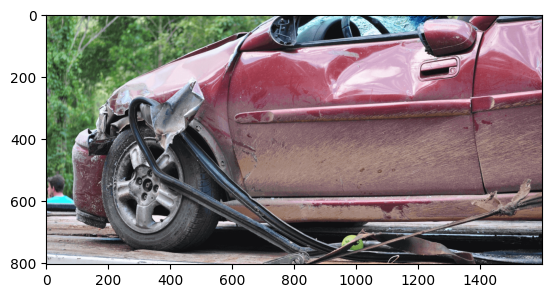

In [10]:
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

img = Image.open("testCar.png")

plt.imshow(img)

plt.show()

In [11]:
result = model.predict("testCar.png",conf = 0.1,save = True)

print(result[0])


image 1/1 c:\Projects\InsuranceAutomation\testCar.png: 352x640 4 dents, 1 tire flat, 58.1ms
Speed: 2.0ms preprocess, 58.1ms inference, 4.5ms postprocess per image at shape (1, 3, 352, 640)
Results saved to runs\detect\train52
ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'dent', 1: 'scratch', 2: 'crack', 3: 'glass shatter', 4: 'lamp broken', 5: 'tire flat'}
obb: None
orig_img: array([[[120, 146, 125],
        [115, 149, 100],
        [ 96, 147,  94],
        ...,
        [171, 144, 118],
        [171, 144, 118],
        [171, 144, 118]],

       [[120, 146, 125],
        [115, 149, 100],
        [115, 149, 100],
        ...,
        [172, 153, 140],
        [171, 144, 118],
        [172, 153, 140]],

       [[120, 146, 125],
        [115, 149, 100],
        [104, 146, 118],
        ...,
        [171, 144, 118],
        [171, 144, 118],
        [171, 144, 118]],

       ...,

       [[21